In [ ]:
import sys
sys.path.append('/home/sdeepak/GNN/graph_nets/Granular_GNN')
import numpy as np
import pandas as pd
import os
import utils_np
import modules as models
import utils_tf
import graphs
import blocks 


CURRENT_DIR = os.getcwd()
DATA_PATH = os.path.join(CURRENT_DIR, "csv data files for 20 stages")
TIMESTEPS = 21  # t = 0 to 20
print("Notebook started")


def load_targets(t):
    # filepath: /home/sdeepak/GNN/graph_nets/Granular_GNN/test.ipynb
    # Reads the NPMNCF file for timestep t and returns a [num_nodes, 1] array
    fname = os.path.join(DATA_PATH, f"{t}_ball_NPMNCF.tab")
    df = pd.read_csv(fname, delim_whitespace=True, header=None, skiprows=2, names=["ball_id", "npmncf"])
    df.sort_values("ball_id", inplace=True)  # Ensure order matches node feature construction
    return df["npmncf"].values.reshape(-1, 1)



def load_scalar_feat(name, t):
    # For files like 0_ball_rad.tab, which are space-separated and have 2 header lines
    print(f"load_scalar_feat called for {name}, t={t}")
    return pd.read_csv(
        f"{DATA_PATH}/{t}_{name}.tab",
        header=None,
        names=["ball_id", name],
        delim_whitespace=True,
        skiprows=2
    )

def load_all_node_data(t):
    
    print(f"load_all_node_data called for t={t}")  # Add this
    df = load_scalar_feat("ball_rad", t)
    df = df.merge(load_scalar_feat("ball_cn", t), on="ball_id")
    for name in ["ball_disp_x", "ball_disp_y", "ball_disp_z",
                 "ball_pos_x", "ball_pos_y", "ball_pos_z"]:
        df = df.merge(load_scalar_feat(name, t), on="ball_id")
    df.sort_values("ball_id", inplace=True)
    return df

def load_edges(t, id_to_idx):
    e1 = pd.read_csv(f"{DATA_PATH}/{t}_contact_end1.tab", delim_whitespace=True, header=None, skiprows=2)
    e2 = pd.read_csv(f"{DATA_PATH}/{t}_contact_end2.tab", delim_whitespace=True, header=None, skiprows=2)
    print(f"First few rows of {t}_contact_end1.tab:")
    print(e1.head())
    print(f"First few rows of {t}_contact_end2.tab:")
    print(e2.head())
    # Use the first column only
    e1_ids = e1.iloc[:, 0].astype(int)
    e2_ids = e2.iloc[:, 0].astype(int)
    # Only keep edges where both endpoints exist in id_to_idx
    valid_edges = []
    for a, b in zip(e1_ids, e2_ids):
        if a in id_to_idx and b in id_to_idx:
            valid_edges.append((id_to_idx[a], id_to_idx[b]))
    return set(valid_edges)

def compute_displacement_features(pos, disp, i, j, max_r):
    rel_pos = pos[i] - pos[j]
    rel_disp = disp[i] - disp[j]

    if np.linalg.norm(rel_pos) < 1e-6:
        return [0.0, 0.0]

    contact_dir = rel_pos / np.linalg.norm(rel_pos)
    disp_along = np.dot(rel_disp, contact_dir)
    disp_perp = np.linalg.norm(rel_disp - disp_along * contact_dir)

    return [disp_along / max_r, disp_perp / max_r]

def create_all_graphs():
    print("create_all_graphs called")

    graphs = []

    node_data_0 = load_all_node_data(0)
    # Ensure IDs are int for consistent mapping
    # Maps each ball_id to its row index in the DataFrame.
    id_to_idx = {int(bid): i for i, bid in enumerate(node_data_0["ball_id"])}
    # Find Maximum Radius
    max_r = node_data_0["ball_rad"].max()


    print("First 10 node IDs:", list(id_to_idx.keys())[:10])

    ### Graph 0 ###
    print("Building Graph 0...")

    # Build Node Features
    nodes_0 = np.stack([
        node_data_0["ball_rad"] / max_r,
        node_data_0["ball_cn"]
    ], axis=1).astype(np.float32)

    # Loads all edges for t=0, using the mapping to ensure both endpoints exist.

    edges_0 = load_edges(0, id_to_idx)
    senders, receivers = zip(*edges_0) if edges_0 else ([], [])
    # Edge Features
    edge_features = [[0.0, 0.0, 0.0]] * len(senders)
    # Graph Dictionary
    '''This dictionary contains all the data needed to represent the 
    graph at t=0.'''

    graph_0 = {
        "globals": np.zeros([1], dtype=np.float32),
        "nodes": nodes_0,
        "edges": np.array(edge_features, dtype=np.float32),
        "senders": np.array(senders, dtype=np.int32),
        "receivers": np.array(receivers, dtype=np.int32)
    }
    graphs.append(graph_0)

    ### Graphs 1 to 20 ###
    for t in range(1, TIMESTEPS):
        print(f"Building Graph {t}...")
        node_data_t = load_all_node_data(t)
        disp_t = node_data_t[["ball_disp_x", "ball_disp_y", "ball_disp_z"]].values
        pos_t = node_data_t[["ball_pos_x", "ball_pos_y", "ball_pos_z"]].values

        nodes = np.stack([
            node_data_t["ball_rad"] / max_r,
            node_data_t["ball_cn"]
        ], axis=1).astype(np.float32)

        edges_prev = load_edges(t-1, id_to_idx)
        edges_curr = load_edges(t, id_to_idx)
        all_edges = list(edges_prev.union(edges_curr))

        edge_features = []
        for (i, j) in all_edges:
            # Contact evolution status
            if (i, j) in edges_prev and (i, j) in edges_curr:
                status = 0.0
            elif (i, j) in edges_prev:
                status = -1.0
            else:
                status = 1.0
            # Relative displacement
            disp_feat = compute_displacement_features(pos_t, disp_t, i, j, max_r)
            edge_features.append([status] + disp_feat)

        senders, receivers = zip(*all_edges) if all_edges else ([], [])
        graph = {
            "globals": np.zeros([1], dtype=np.float32),
            "nodes": nodes,
            "edges": np.array(edge_features, dtype=np.float32),
            "senders": np.array(senders, dtype=np.int32),
            "receivers": np.array(receivers, dtype=np.int32)
        }
        graphs.append(graph)



    return [utils_np.data_dicts_to_graphs_tuple([g]) for g in graphs]


Notebook started


In [4]:
graphs = create_all_graphs()

create_all_graphs called
load_all_node_data called for t=0
load_scalar_feat called for ball_rad, t=0
load_scalar_feat called for ball_cn, t=0
load_scalar_feat called for ball_disp_x, t=0
load_scalar_feat called for ball_disp_y, t=0
load_scalar_feat called for ball_disp_z, t=0
load_scalar_feat called for ball_pos_x, t=0
load_scalar_feat called for ball_pos_y, t=0
load_scalar_feat called for ball_pos_z, t=0
First 10 node IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Building Graph 0...
First few rows of 0_contact_end1.tab:
     0    1
0  1.0  4.0
1  2.0  1.0
2  3.0  1.0
3  4.0  1.0
4  5.0  2.0
First few rows of 0_contact_end2.tab:
     0       1
0  1.0   638.0
1  2.0  1513.0
2  3.0  1856.0
3  4.0  3316.0
4  5.0  1529.0
Building Graph 1...
load_all_node_data called for t=1
load_scalar_feat called for ball_rad, t=1
load_scalar_feat called for ball_cn, t=1
load_scalar_feat called for ball_disp_x, t=1
load_scalar_feat called for ball_disp_y, t=1
load_scalar_feat called for ball_disp_z, t=1
load_scala

In [ ]:
import models

# Training code of GNN model




# --- Hyperparameters ---
num_epochs = 25
batch_size = 8
num_processing_steps = 7
learning_rate = 1e-4
clip_norm = 1.0


# train_graph_dicts: list of dicts with keys: nodes, edges, senders, receivers, globals (optional)
# train_targets: list of arrays, each shape [num_nodes, 1] (NPMNCF per node)
# test_graph_dicts, test_targets: same for test set

graphs = create_all_graphs()
targets = [load_targets(t) for t in range(TIMESTEPS)]  # List of arrays, each [num_nodes, 1]

# Example split (adjust as needed)
train_graph_dicts = graphs[:16]
train_targets = targets[:16]
test_graph_dicts = graphs[16:]
test_targets = targets[16:]
# --- Model ---
model = models.EncodeProcessDecode(
    edge_output_size=3,
    node_output_size=2,
    global_output_size=None,
   
)

# --- Placeholders ---
input_graph_ph = utils_tf.placeholders_from_data_dicts([train_graph_dicts[0]])
target_nodes_ph = tf.placeholder(tf.float32, shape=[None, 1])

# --- Forward Pass ---
output_graphs = model(input_graph_ph, num_processing_steps)
# Use the last step's output for loss
pred_nodes = output_graphs[-1].nodes

# --- Losses ---
l1_loss = tf.reduce_mean(tf.abs(pred_nodes - target_nodes_ph))
l2_loss = tf.reduce_mean(tf.square(pred_nodes - target_nodes_ph))

# --- Optimizer ---
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, variables = zip(*optimizer.compute_gradients(l2_loss))
gradients, _ = tf.clip_by_global_norm(gradients, clip_norm)
train_op = optimizer.apply_gradients(zip(gradients, variables))

# --- Pearson Correlation ---
def pearson_corr(x, y):
    x_mean = tf.reduce_mean(x)
    y_mean = tf.reduce_mean(y)
    xm, ym = x - x_mean, y - y_mean
    r_num = tf.reduce_sum(xm * ym)
    r_den = tf.sqrt(tf.reduce_sum(xm ** 2)) * tf.sqrt(tf.reduce_sum(ym ** 2))
    return r_num / (r_den + 1e-8)

rho = pearson_corr(pred_nodes, target_nodes_ph)

# --- Training Loop ---
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    best_rho_test = -np.inf

    for epoch in range(num_epochs):
        # Shuffle training data
        idx = np.random.permutation(len(train_graph_dicts))
        train_graph_dicts = [train_graph_dicts[i] for i in idx]
        train_targets = [train_targets[i] for i in idx]

        # Training
        l1s, l2s, rhos = [], [], []
        for i in range(0, len(train_graph_dicts), batch_size):
            batch_graphs = train_graph_dicts[i:i+batch_size]
            batch_targets = train_targets[i:i+batch_size]
            # Convert to GraphsTuple
            batch_graphs_tuple = utils_tf.data_dicts_to_graphs_tuple(batch_graphs)
            batch_targets_concat = np.concatenate(batch_targets, axis=0)
            feed_dict = {
                input_graph_ph: batch_graphs_tuple,
                target_nodes_ph: batch_targets_concat
            }
            _, l1, l2, r = sess.run([train_op, l1_loss, l2_loss, rho], feed_dict=feed_dict)
            l1s.append(l1)
            l2s.append(l2)
            rhos.append(r)

        # Evaluation
        l1s_test, l2s_test, rhos_test = [], [], []
        for i in range(0, len(test_graph_dicts), batch_size):
            batch_graphs = test_graph_dicts[i:i+batch_size]
            batch_targets = test_targets[i:i+batch_size]
            batch_graphs_tuple = utils_tf.data_dicts_to_graphs_tuple(batch_graphs)
            batch_targets_concat = np.concatenate(batch_targets, axis=0)
            feed_dict = {
                input_graph_ph: batch_graphs_tuple,
                target_nodes_ph: batch_targets_concat
            }
            l1, l2, r = sess.run([l1_loss, l2_loss, rho], feed_dict=feed_dict)
            l1s_test.append(l1)
            l2s_test.append(l2)
            rhos_test.append(r)

        # Aggregate metrics
        L1_train, L2_train, rho_train = np.mean(l1s), np.mean(l2s), np.mean(rhos)
        L1_test, L2_test, rho_test = np.mean(l1s_test), np.mean(l2s_test), np.mean(rhos_test)

        print(f"Epoch {epoch+1:03d}: "
              f"L1_train={L1_train:.4f}, L2_train={L2_train:.4f}, rho_train={rho_train:.4f} | "
              f"L1_test={L1_test:.4f}, L2_test={L2_test:.4f}, rho_test={rho_test:.4f}")

        # Checkpoint
        if rho_test > best_rho_test:
            best_rho_test = rho_test
            saver = tf.train.Saver()
            saver.save(sess, "./best_gnn_model.ckpt")
            print("Model checkpointed.")

print("Training complete.")



load_all_node_data called for t=0
load_scalar_feat called for ball_rad, t=0
load_scalar_feat called for ball_cn, t=0
load_scalar_feat called for ball_disp_x, t=0
load_scalar_feat called for ball_disp_y, t=0
load_scalar_feat called for ball_disp_z, t=0
load_scalar_feat called for ball_pos_x, t=0
load_scalar_feat called for ball_pos_y, t=0
load_scalar_feat called for ball_pos_z, t=0
Plotted node IDs (up to 10): {1856, 1, 2, 3, 4, 1513, 3500, 3316, 1529, 3484, 638}
Edges (sender -> receiver, spatially close): [(4, 638), (1, 1513), (1, 1856), (1, 3316), (2, 1529), (2, 3500), (3, 3484)]


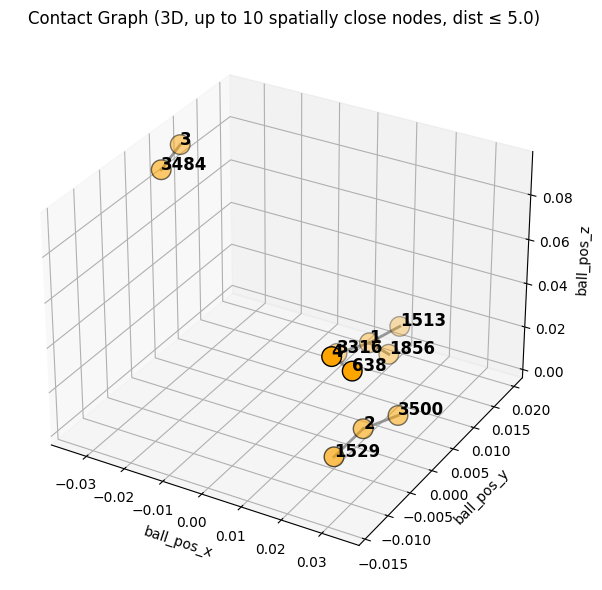

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

DIST_THRESHOLD = 5.0  # Set your distance threshold here

if 'graphs' in locals():
    node_data_0 = load_all_node_data(0)
    pos_x = node_data_0["ball_pos_x"].values
    pos_y = node_data_0["ball_pos_y"].values
    pos_z = node_data_0["ball_pos_z"].values
    ball_ids = node_data_0["ball_id"].values.astype(int)
    id_to_idx = {int(bid): i for i, bid in enumerate(ball_ids)}

    DATA_PATH = "csv data files for 20 stages"
    e1 = pd.read_csv(f"{DATA_PATH}/0_contact_end1.tab", delim_whitespace=True, header=None, skiprows=2)
    e2 = pd.read_csv(f"{DATA_PATH}/0_contact_end2.tab", delim_whitespace=True, header=None, skiprows=2)
    sender_ids = e1.iloc[:, 1].astype(int).values
    receiver_ids = e2.iloc[:, 1].astype(int).values

    close_edges = []
    node_ids = set()
    for s_id, r_id in zip(sender_ids, receiver_ids):
        if s_id in id_to_idx and r_id in id_to_idx:
            s_idx = id_to_idx[s_id]
            r_idx = id_to_idx[r_id]
            dist = np.linalg.norm([
                pos_x[s_idx] - pos_x[r_idx],
                pos_y[s_idx] - pos_y[r_idx],
                pos_z[s_idx] - pos_z[r_idx]
            ])
            if dist <= DIST_THRESHOLD:
                if len(node_ids) < 10 or s_id in node_ids or r_id in node_ids:
                    close_edges.append((s_id, r_id))
                    node_ids.add(s_id)
                    node_ids.add(r_id)
                if len(node_ids) >= 10:
                    break

    # Build the graph with only these 10 nodes and their close edges
    G = nx.DiGraph()
    label_pos = {}
    for nid in node_ids:
        idx = id_to_idx[nid]
        G.add_node(nid)
        label_pos[nid] = (pos_x[idx], pos_y[idx], pos_z[idx])
    for s_id, r_id in close_edges:
        if s_id in node_ids and r_id in node_ids:
            G.add_edge(s_id, r_id)

    print(f"Plotted node IDs (up to 10): {node_ids}")
    print("Edges (sender -> receiver, spatially close):", close_edges)

    # 3D Plotting
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Draw nodes
    xs = [label_pos[nid][0] for nid in G.nodes]
    ys = [label_pos[nid][1] for nid in G.nodes]
    zs = [label_pos[nid][2] for nid in G.nodes]
    ax.scatter(xs, ys, zs, s=200, c='orange', edgecolors='k', depthshade=True)

    # Draw edges
    for s_id, r_id in G.edges:
        x = [label_pos[s_id][0], label_pos[r_id][0]]
        y = [label_pos[s_id][1], label_pos[r_id][1]]
        z = [label_pos[s_id][2], label_pos[r_id][2]]
        ax.plot(x, y, z, c='gray', linewidth=2, alpha=0.8)

    # Draw labels
    for nid in G.nodes:
        ax.text(label_pos[nid][0], label_pos[nid][1], label_pos[nid][2], str(nid),
                color='black', fontsize=12, weight='bold')

    ax.set_xlabel("ball_pos_x")
    ax.set_ylabel("ball_pos_y")
    ax.set_zlabel("ball_pos_z")
    ax.set_title(f"Contact Graph (3D, up to 10 spatially close nodes, dist ≤ {DIST_THRESHOLD})")
    plt.tight_layout()
    plt.show()
else:
    print("No graphs to plot.")

TypeError: 'ellipsis' object is not iterable

load_all_node_data called for t=0
load_scalar_feat called for ball_rad, t=0
load_scalar_feat called for ball_cn, t=0
load_scalar_feat called for ball_disp_x, t=0
load_scalar_feat called for ball_disp_y, t=0
load_scalar_feat called for ball_disp_z, t=0
load_scalar_feat called for ball_pos_x, t=0
load_scalar_feat called for ball_pos_y, t=0
load_scalar_feat called for ball_pos_z, t=0
Plotted node IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 

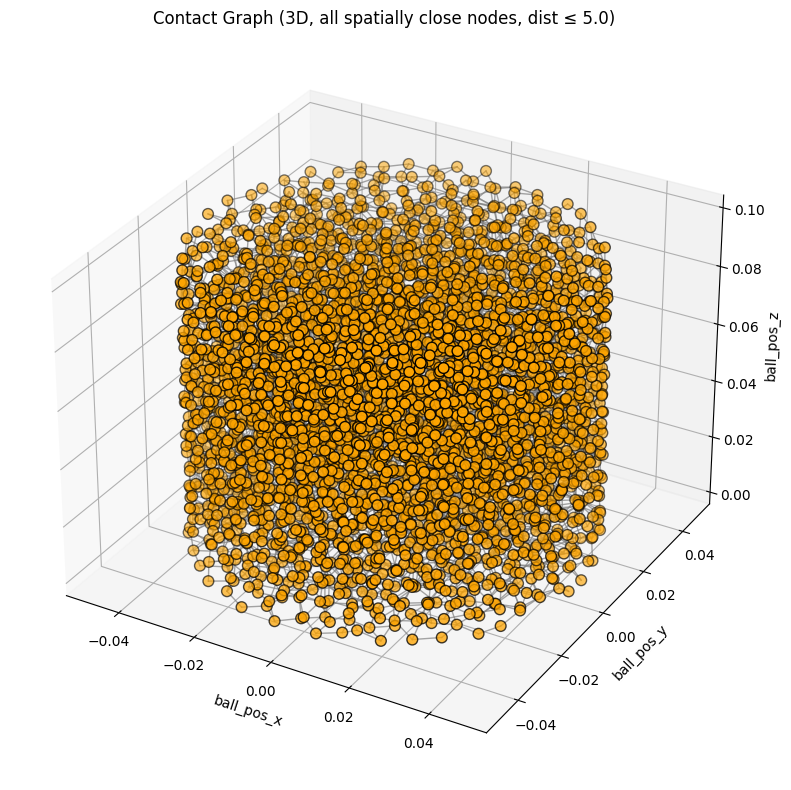

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

DIST_THRESHOLD = 5.0  # Set your distance threshold here

if 'graphs' in locals():
    node_data_0 = load_all_node_data(0)
    pos_x = node_data_0["ball_pos_x"].values
    pos_y = node_data_0["ball_pos_y"].values
    pos_z = node_data_0["ball_pos_z"].values
    ball_ids = node_data_0["ball_id"].values.astype(int)
    id_to_idx = {int(bid): i for i, bid in enumerate(ball_ids)}

    DATA_PATH = "csv data files for 20 stages"
    e1 = pd.read_csv(f"{DATA_PATH}/0_contact_end1.tab", delim_whitespace=True, header=None, skiprows=2)
    e2 = pd.read_csv(f"{DATA_PATH}/0_contact_end2.tab", delim_whitespace=True, header=None, skiprows=2)
    sender_ids = e1.iloc[:, 1].astype(int).values
    receiver_ids = e2.iloc[:, 1].astype(int).values

    close_edges = []
    node_ids = set()
    for s_id, r_id in zip(sender_ids, receiver_ids):
        if s_id in id_to_idx and r_id in id_to_idx:
            s_idx = id_to_idx[s_id]
            r_idx = id_to_idx[r_id]
            dist = np.linalg.norm([
                pos_x[s_idx] - pos_x[r_idx],
                pos_y[s_idx] - pos_y[r_idx],
                pos_z[s_idx] - pos_z[r_idx]
            ])
            if dist <= DIST_THRESHOLD:
                close_edges.append((s_id, r_id))
                node_ids.add(s_id)
                node_ids.add(r_id)

    # Build the graph with all nodes and their close edges
    G = nx.DiGraph()
    label_pos = {}
    for nid in node_ids:
        idx = id_to_idx[nid]
        G.add_node(nid)
        label_pos[nid] = (pos_x[idx], pos_y[idx], pos_z[idx])
    for s_id, r_id in close_edges:
        G.add_edge(s_id, r_id)

    print(f"Plotted node IDs: {node_ids}")
    print("Edges (sender -> receiver, spatially close):", close_edges)

    # 3D Plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Draw nodes
    xs = [label_pos[nid][0] for nid in G.nodes]
    ys = [label_pos[nid][1] for nid in G.nodes]
    zs = [label_pos[nid][2] for nid in G.nodes]
    ax.scatter(xs, ys, zs, s=60, c='orange', edgecolors='k', depthshade=True)

    # Draw edges
    for s_id, r_id in G.edges:
        x = [label_pos[s_id][0], label_pos[r_id][0]]
        y = [label_pos[s_id][1], label_pos[r_id][1]]
        z = [label_pos[s_id][2], label_pos[r_id][2]]
        ax.plot(x, y, z, c='gray', linewidth=1, alpha=0.7)

    # Optionally, draw labels (comment out for large graphs)
    # for nid in G.nodes:
    #     ax.text(label_pos[nid][0], label_pos[nid][1], label_pos[nid][2], str(nid),
    #             color='black', fontsize=8, weight='bold')

    ax.set_xlabel("ball_pos_x")
    ax.set_ylabel("ball_pos_y")
    ax.set_zlabel("ball_pos_z")
    ax.set_title(f"Contact Graph (3D, all spatially close nodes, dist ≤ {DIST_THRESHOLD})")
    plt.tight_layout()
    plt.show()
else:
    print("No graphs to plot.")